In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as st
import pingouin as pg
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

¿Cómo lidiar con los sujetos que abandonan un estudio?

Ej: supongamos que probamos un nuevo medicamento contra el cáncer. 

Mientras que algunos sujetos mueren, otros pueden creer que el nuevo fármaco no es efectivo y deciden abandonar el estudio antes de que finalice. 

Ej: investigar cuánto tiempo dura una máquina antes de que se averíe, o cuánto tiempo las personas se suscriben a las listas de correo (donde la "muerte" corresponde a darse de baja de una lista de correo).

# 10.1 Distribuciones de Supervivencia

La distribución de Weibull se usa para modelar datos de confiabilidad o datos de supervivencia. 

También llamado distribución Fréchet. 

La distribución de Weibull se caracteriza por un parámetro de forma, el módulo $k$ de Weibull. 

In [2]:
# Genere algunos datos de muestra, con un módulo de Weibull de 1.5
WeibullDist = stats.weibull_min(1.5)
data = WeibullDist.rvs(500)

In [3]:
# Ajuste el parámetro
fitPars = stats.weibull_min.fit(data)
fitPars

(1.5062507245554997, 0.021445067747171885, 0.9979403844962673)

In [4]:
# fitPars contiene (WeibullModulus, Location, Scale)
print(f'El módulo de Weibull ajustado es {fitPars[0]:5.2f}, en comparación con el valor exacto de 1.5.')

El módulo de Weibull ajustado es  1.51, en comparación con el valor exacto de 1.5.


# 10.2 Probabilidades de supervivencia

## 10.2.1 Censura

La dificultad de usar datos para el análisis de supervivencia es que, al final de un estudio, muchas personas pueden estar todavía "vivas". 

Censura: valores de medición que solo se conocen parcialmente. 

Ej: una lista de correo cuyos suscriptores se dividen en 2 subgrupos. 

Grupo Uno: se cansa rápidamente de los correos electrónicos y se da de baja después de 3 meses. 

Grupo Dos: lo disfruta y generalmente se suscribe por un año y medio. 

Realizamos un estudio que dura un año y queremos investigar la duración promedio de suscripción:

In [9]:
from numpy.random import uniform, exponential
from lifelines.plotting import plot_lifetimes

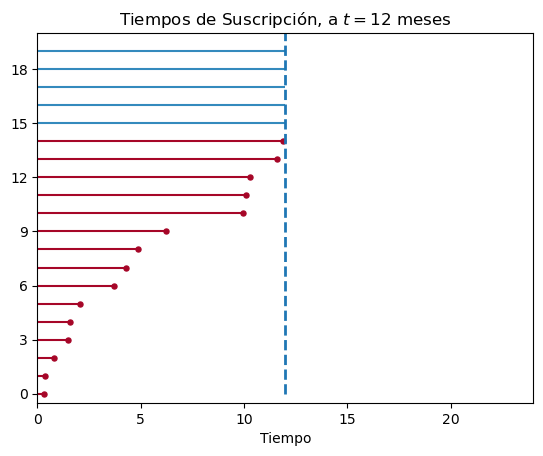

In [10]:
# Generar algunos datos ficticios
np.set_printoptions(precision=2)
N = 20
study_duration = 12
    
# Nota: ¡una tasa de deserción constante es equivalente a una distribución exponencial!
subsciption_list = [ [exponential(18), exponential(3)][uniform()<0.5] for i in range(N) ]
actual_subscriptiontimes = np.array(subsciption_list)
observed_subscriptiontimes = np.minimum(actual_subscriptiontimes,study_duration)
observed= actual_subscriptiontimes < study_duration
    
# Grafico
plot_lifetimes(observed_subscriptiontimes, event_observed=observed)

plt.xlim(0,24)
plt.vlines(12, 0, 30, lw=2, linestyles="--")
plt.xlabel('Tiempo')
plt.title('Tiempos de Suscripción, a $t=12$ meses')

plt.show()

In [12]:
print(f'Tiempo de suscripción observado a tiempo {study_duration:d}\n', observed_subscriptiontimes)

Tiempo de suscripción observado a tiempo 12
 [ 6.24 10.27  1.49 12.    4.87  4.28 11.86  3.72  0.38  2.04 12.    0.31
  0.8   9.96 12.   11.61  1.55 10.09 12.   12.  ]


Las líneas rojas indican el tiempo de suscripción de los individuos donde se ha observado el evento de abandono, y las líneas azules indican el tiempo de suscripción de los individuos censurados por la derecha (no se han observado abandonos). 

Si se nos pide que estimemos el tiempo promedio de suscripción de nuestra población, e ingenuamente decidimos no incluir a los individuos censurados por la derecha, está claro que estaríamos muy por debajo de la estimación del verdadero tiempo promedio de suscripción. 

Otro problema similar ocurre si algunos sujetos aumentan su configuración de privacidad en medio del estudio, es decir, nos prohíben monitorearlos antes de que finalice el estudio. 

Estos datos son datos censurados por la derecha.

## 10.2.2 Curva de supervivencia de Kaplan-Meier

Primero, el tiempo se subdivide en pequeños períodos. 

Luego se calcula la probabilidad de que un sujeto sobreviva un período dado. 

$ p_k = p_{k-1}*\frac{r_k - f_k}{r_k} $,

donde
- $p_k$: probabilidad de sobrevivir al periodo $k$
- $r_k$: número de sujetos que todavía están en riesgo (todavía en seguimiento) inmediatamente antes del k-ésimo día
- $f_k$: número de fallas observadas en el día k. 

La curva que describe la probabilidad de supervivencia resultante se llama tabla de vida, curva de supervivencia o curva de Kaplan-Meier.

Ej: Los datos muestran los resultados de un estudio con moscas de la fruta del género Drosophila. 

Los números dan los genotipos de las moscas y el número de días de supervivencia. 

Como trabajamos con moscas, no tenemos que preocuparnos por la censura a la izquierda: sabemos la fecha de nacimiento de todas las moscas. 

Tenemos problemas con matar accidentalmente a algunos o si algunos escapan. 

Estos serían censurados por la derecha ya que en realidad no observamos su muerte debido a causas "naturales".

In [13]:
from lifelines.datasets import load_waltons
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [14]:
# Datos
df = load_waltons() 
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [15]:
T = df['T']
E = df['E']

In [16]:
groups = df['group']
ix = (groups == 'miR-137')

In [17]:
kmf = KaplanMeierFitter()
kmf

<lifelines.KaplanMeierFitter>

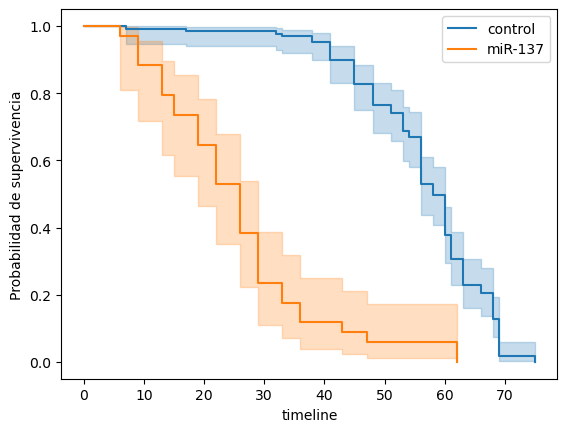

In [18]:
kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='miR-137')
kmf.plot(ax=ax)

plt.ylabel('Probabilidad de supervivencia')

plt.show()

In [19]:
# Compara las dos curvas
results = logrank_test(T[ix], T[~ix], event_observed_A=E[ix], event_observed_B=E[~ix])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         122.25 <0.005     91.99

La curva de supervivencia cambia solo cuando ocurre un "fracaso", es decir, cuando un sujeto muere. 

Las entradas censuradas, que describen cuándo un sujeto abandona el estudio o cuándo finaliza el estudio, se tienen en cuenta en los momentos de "fallo", pero por lo demás no afectan la curva de supervivencia.

In [25]:
data_1 = np.genfromtxt(r'Datos/altman_13_2.txt', delimiter=',')

data_1

array([[ 30.,   0.],
       [ 50.,   0.],
       [ 50.,   1.],
       [ 51.,   0.],
       [ 66.,   1.],
       [ 82.,   0.],
       [ 92.,   0.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.]])

In [26]:
data_2 = np.genfromtxt(r'Datos/altman_13_3.txt', delimiter=',')

data_2

array([[  5.,   0.],
       [  6.,   1.],
       [ 11.,   0.],
       [ 11.,   0.],
       [ 13.,   0.],
       [ 24.,   0.],
       [ 63.,   0.],
       [ 65.,   0.],
       [ 69.,   0.],
       [ 69.,   0.],
       [ 79.,   0.],
       [ 82.,   0.],
       [ 82.,   0.],
       [102.,   0.],
       [115.,   0.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.],
       [120.,   1.]])

In [27]:
def kaplanmeier(data):
    '''Determine y la curva de Kaplan-Meier para los datos dados. 
    Los tiempos censurados se indican con "1" en la segunda columna, los no censurados con "0"
    '''
    
    times = data[:,0]
    censored = data[:,1]
    atRisk = np.arange(len(times),0,-1)
    
    failures = times[censored==0]
    num_failures = len(failures)
    p = np.ones(num_failures+1)
    r = np.zeros(num_failures+1)
    se = np.zeros(num_failures+1)
    
    # Calcule los números en riesgo, la probabilidad de supervivencia y el error estándar
    for i in range(num_failures):
        if failures[i] == failures[i-1]:
            r[i+1] = r[i]
            p[i+1] = p[i]
            se[i+1] = se[i]
            
        else:
            r[i+1] = np.max(atRisk[times==failures[i]])
            p[i+1] = p[i] * (r[i+1] - sum(failures==failures[i]))/r[i+1]
            se[i+1] = p[i+1]*np.sqrt((1-p[i+1])/r[i+1])
            # ci = p +/- 1.96 se
    
    # Grafico la curva de supervivencia (curva Kaplan-Meier)
    # Comience siempre en t=0 y p=1, y haga una línea hasta la última medición
    
    t = np.hstack((0, failures, np.max(times)))
    sp = np.hstack((p, p[-1]))
    
    return(p,atRisk,t,sp,se)

In [28]:
# Determinar las curvas de Kaplan-Meier
(p1, r1, t1, sp1,se1) = kaplanmeier(data_1)
(p2, r2, t2, sp2,se2) = kaplanmeier(data_2)

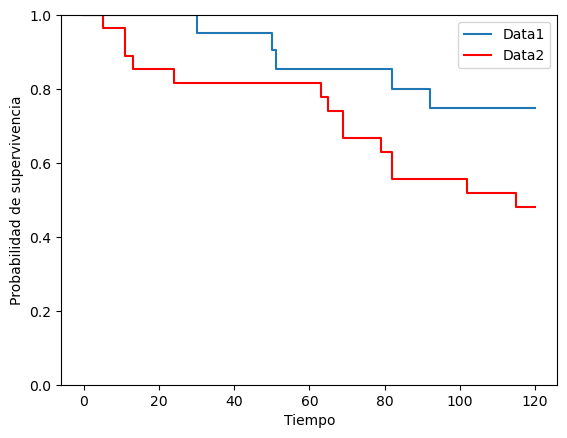

In [32]:
# Hacer un gráfico combinado para ambos conjuntos de datos
plt.step(t1,sp1, where='post')
plt.step(t2,sp2,'r', where='post')

plt.legend(['Data1', 'Data2'])
plt.ylim(0,1)
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de supervivencia')

plt.show()

# 10.3 Comparación de las curvas de supervivencia en dos grupos

Prueba de rango logarítmico: compara grupos independientes de tiempos de supervivencia. 

Es una prueba de hipótesis no paramétrica, que prueba la probabilidad de que ambos grupos provengan de la misma población subyacente. 

In [33]:
times_1 = data_1[:,0]

censored_1 = data_1[:,1]

atRisk_1 = np.arange(len(times_1),0,-1)

failures_1 = times_1[censored_1==0]

In [34]:
times_2 = data_2[:,0]

censored_2 = data_2[:,1]

atRisk_2 = np.arange(len(times_2),0,-1)

failures_2 = times_2[censored_2==0]

In [35]:
failures = np.unique(np.hstack((times_1[censored_1==0], times_2[censored_2==0])))

num_failures = len(failures)

r1 = np.zeros(num_failures)
r2 = np.zeros(num_failures)
r  = np.zeros(num_failures)

f1 = np.zeros(num_failures)
f2 = np.zeros(num_failures)
f  = np.zeros(num_failures)

e1 = np.zeros(num_failures)

f1me1 = np.zeros(num_failures)

v = np.zeros(num_failures)

In [36]:
for i in range(num_failures):
    r1[i] = np.sum(times_1 >= failures[i])
    r2[i] = np.sum(times_2 >= failures[i])
    r[i] = r1[i] + r2[i]
    
    f1[i] = np.sum(failures_1==failures[i])
    f2[i] = np.sum(failures_2==failures[i])
    f[i] = f1[i] + f2[i]
    
    e1[i] = r1[i]*f[i]/r[i]
    f1me1[i] = f1[i] - e1[i]
    v[i] = r1[i]*r2[i]*f[i]*(r[i]-f[i]) / ( r[i]**2 *(r[i]-1) )

    O1 = np.sum(f1)
    O2 = np.sum(f2)
    E1 = np.sum(e1)
    O1mE1 = np.sum(f1me1)
    V = sum(v)

In [37]:
chi2 = (O1-E1)**2/V

p = stats.chi2.sf(chi2, 1)

In [41]:
print(f'Chi2 = {chi2:5.3f}')

Chi2 = 3.207


In [42]:
if p < 0.05:
    print(f'p={0:6.4f}, las dos curvas de supervivencia son signifcativamente diferentes.')
else:
    print(f'p={0:6.4f}, las dos curvas de supervivencia no son signifcativamente diferentes.')

p=0.0000, las dos curvas de supervivencia no son signifcativamente diferentes.
